In [31]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
from keras import metrics
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import norm

# Hyperparams

In [3]:
batch_size = 100
original_dim = 28*28
latent_dim = 2
intermediate_dim = 256
nb_epoch = 5
epsilon_std = 1.

# Create the sampling helper function

In [8]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Create the encoder

In [9]:
x = Input(shape=(original_dim,), name = 'input')
h = Dense(intermediate_dim, activation='relu',name = 'encoding')(x)

z_mean = Dense(latent_dim, name = 'mean')(h)
z_log_var = Dense(latent_dim, name='log_variance')(h)

# what is sampling ??????
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

encoder = Model(x, [z_mean, z_log_var, z], name='encoder')

# Create the decoder

In [10]:
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
decoder_h = Dense(intermediate_dim, activation='relu')(input_decoder)
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
decoder = Model(input_decoder, x_decoded, name="decoder")


# Combining the model

In [11]:
output_combined = decoder(encoder(x)[2])
vae = Model(x, output_combined)
vae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Model)              (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


# Define the loss function

In [22]:
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor,
            z_log_var=z_log_var, z_mean=z_mean,
            original_dim=original_dim):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(
        1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss


# Compile the model

In [23]:
vae.compile(optimizer='rmsprop', loss=vae_loss)

# Creating the train / test split

In [24]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')/ 255.
x_test = x_test.astype('float32')/ 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Train the model

In [26]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=nb_epoch,
        batch_size=batch_size)


Epoch 1/5
60000/60000 [==============================] - 4s 61us/step - loss: 191.2558
Epoch 2/5
60000/60000 [==============================] - 4s 59us/step - loss: 171.3340
Epoch 3/5
60000/60000 [==============================] - 4s 59us/step - loss: 168.0172
Epoch 4/5
60000/60000 [==============================] - 3s 58us/step - loss: 165.2072
Epoch 5/5
60000/60000 [==============================] - 3s 57us/step - loss: 163.2690


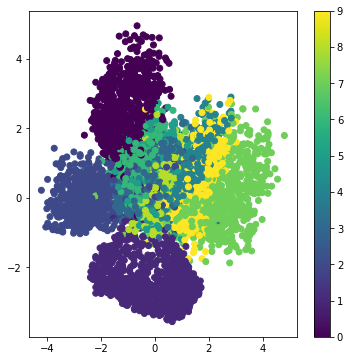

In [29]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()



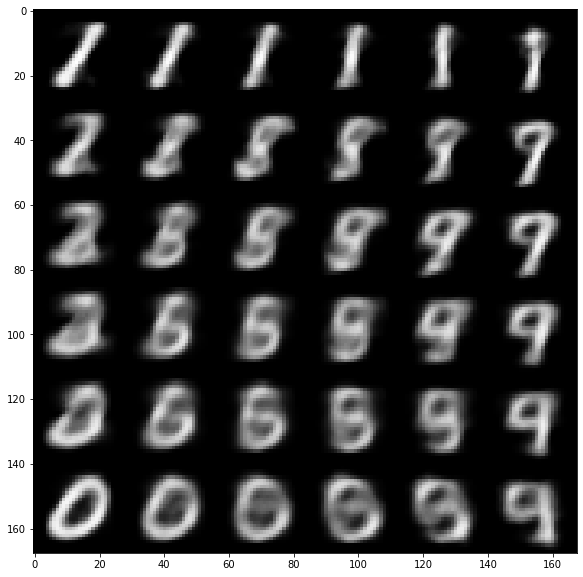

In [33]:
# display a 2D manifold of the digits
n = 6  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()